# 1. Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.
* вариант для 1) Обучите VAE на fashion_mnist
* вариант для 1) Обучите GAN на одном классе CIFAR 




**Закодируем MNIST ограниченной машиной Больцмана применительно, а затем попробуем восстановить изображение с помощью алгоритма марковской цепи Монте-Карло (MCMC) **

In [126]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   
plt.rcParams['image.cmap'] = 'gray'
from keras.datasets import mnist

import pandas as pd

In [127]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

In [128]:
# подключим короткий МНИСТ из примеров sample_data tenserflow

X_train = pd.read_csv('/content/sample_data/mnist_train_small.csv').values[:,1:]
X_train.shape


(19999, 784)

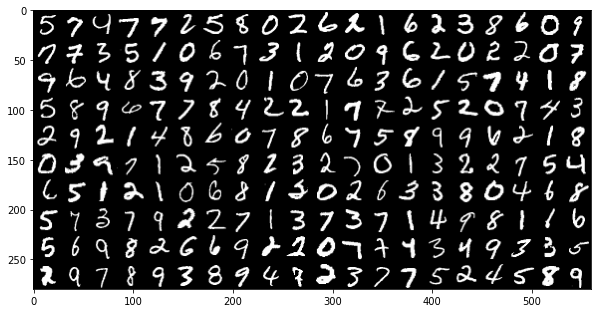

In [129]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(X_train));

In [130]:
from sklearn.neural_network import BernoulliRBM
rbm = BernoulliRBM(n_components=100, learning_rate=0.01, random_state=0, verbose=True)
rbm.fit(X_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25042629.31, time = 5.21s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -50091064.59, time = 5.85s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -75139506.01, time = 5.78s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -100187945.02, time = 5.79s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -125236383.38, time = 5.75s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -150284822.74, time = 5.84s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -175333262.85, time = 5.74s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -200381701.76, time = 5.76s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -225430138.59, time = 5.79s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -250478576.81, time = 5.75s


BernoulliRBM(batch_size=10, learning_rate=0.01, n_components=100, n_iter=10,
             random_state=0, verbose=True)

In [131]:
xx = X_train[:40].copy()
for ii in range(1000):
    for n in range(40):
        xx[n] = rbm.gibbs(xx[n])

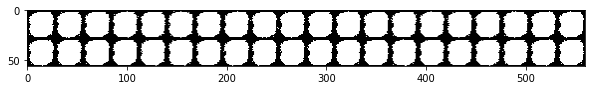

In [132]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(xx))

In [133]:
xx = X_train[:40].copy()
for ii in range(10000):
    for n in range(40):
        xx[n] = rbm.gibbs(xx[n])

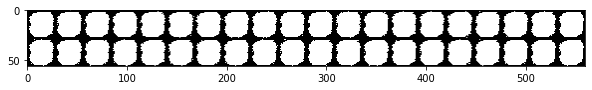

In [134]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(xx))

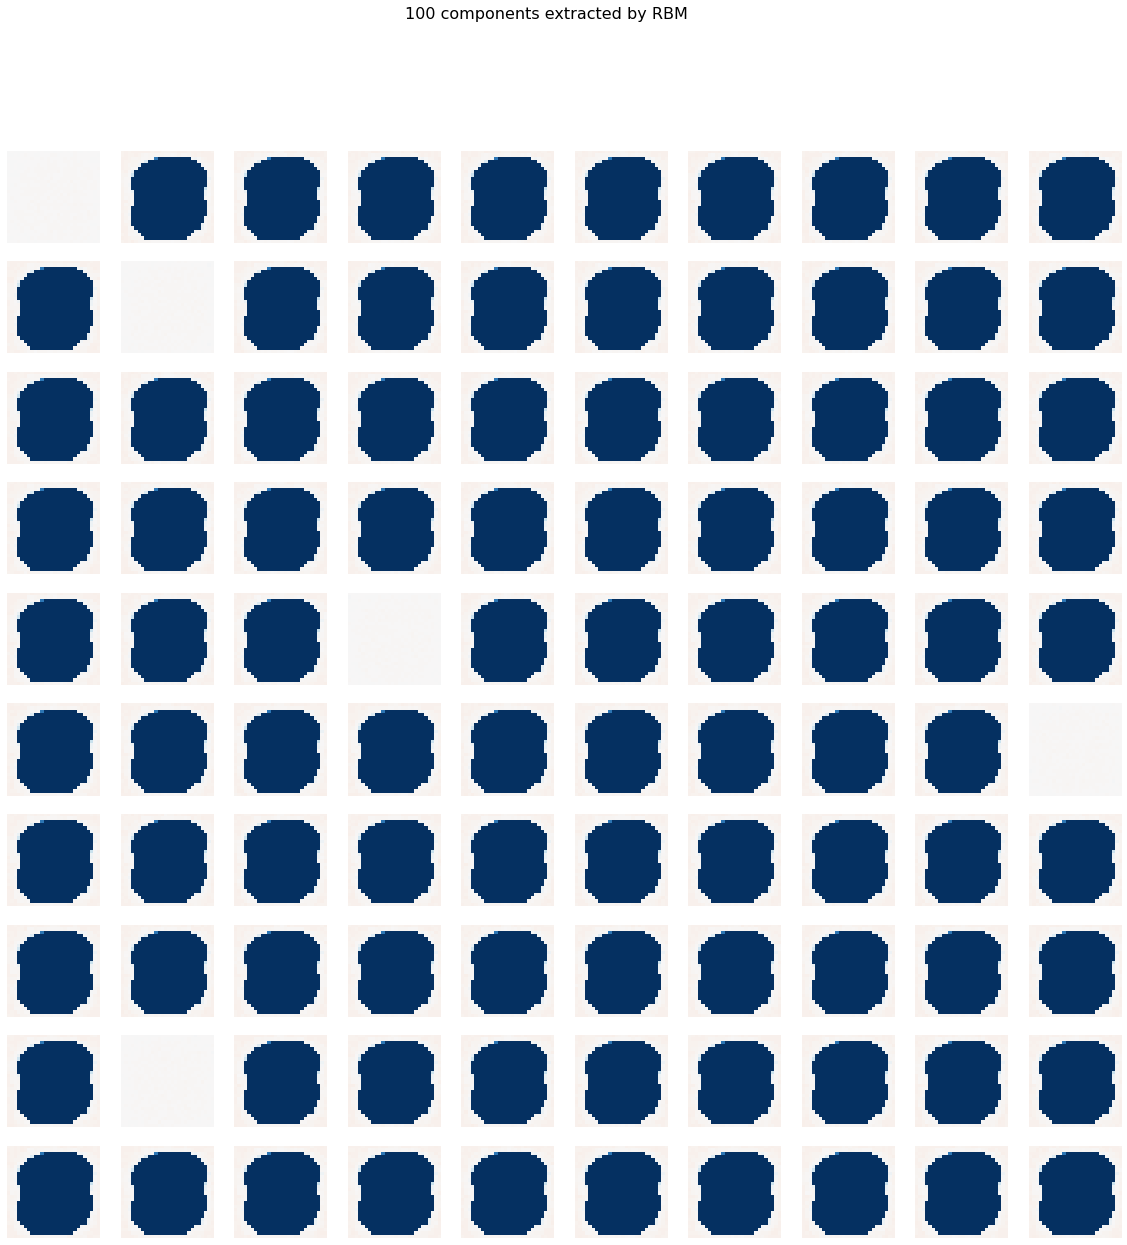

In [135]:
plt.figure(figsize=(20, 20))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.RdBu,
               interpolation='nearest', vmin=-2.5, vmax=2.5)
    plt.axis('off')
plt.suptitle('100 components extracted by RBM', fontsize=16);

Мы должны были получить изображения исходя их их вероятностного распределения. В статье было сказано, что бы должны на выходе получить образы цифр. Но у меня в итоге получилось что-то непонятное. То ли я не понял статью, то ли что-то неправильно сделал. Я очень много раз пересчитывал, причем брал выборку больше, ничего не помагает.  

# 2. Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

**Обзор статьи: «Boltzmann machines and energy-based models»**

В статье рассмотрена архитектура машины Больцмана. Машина Больцмана определяет распределение вероятности по двоичным шаблонам.  
Сеть названа в честь австрийского физика Людвига Больцмана, одного из создателей статистической физики. 
В целом машина Больцмана -  это разновидность стохастической рекуррентной нейронной сети Хопфилда,  которую иногда называют случайными марковскими полями. Одним из основных недостатков сети Хопфилда является тенденция «стабилизации» состояния сети в локальном, а не в глобальном минимуме. 
В машине Больцмана реализована идея использования «теплового шума» для выхода из локальных минимумов и повышения вероятности попадания в более глубокие минимумы. В статье указано, что благодаря такому подходу, машина Больцмана оказалась первой нейронной сетью, способная обучиться решать сложные комбинаторные задачи. 
Несмотря на это, из-за ряда проблем, машины Больцмана с неограниченной связностью не могут использоваться для решения практических задач. 
Процедура обучения машины Больцмана сводится к выполнению следующих чередующихся шагов:

1) Подать на вход сети входной вектор и зафиксировать выходной (как в процедуре обучения с учителем). Предоставить сети возможность приблизиться к состоянию теплового равновесия:
2) В соответствии с правилом Хебба увеличить вес связи между активными нейронами на величину δ. Эти действия повторить для всех пар векторов обучающей выборки.
3) Подать на вход сети входной вектор без фиксации выходного вектора. Повторить пункты 1, 2 Уменьшить вес связи между активными нейронами на величину δ.

Для решения практических задач применяется архитектура ограниченной машины Больцмана.
В этой архитектуре связи существуют только между скрытыми и видимыми нейронами, но при этом отсутствуют между нейронами одного класса. 
Ограниченные машины Больцмана используются в сетях глубинного обучения. В частности, глубокие сети доверия могут быть получены путём «наложения» RBM и последующего дообучения при помощи алгоритма обратного распространения ошибки.
 
Машины Больцмана сложно обучаемы, поэтому в настоящее время практически неприменимы.
